# Fraud Detection with Imbalanced Data - Practical Approach
### Optimized for CPU usage on Kaggle
#### Uses real data patterns instead of SMOTE synthetic generation

## 1. Import Libraries

In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [imbalanced-learn][imbalanced-learn]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load and Explore Data

In [8]:
import pandas as pd

blob_url = (
    "https://creditfraudml6672871583.blob.core.windows.net/"
    "azureml-blobstore-521539cf-a290-4a10-8699-173bdfba39a5/"
    "fraud_dataset.csv"
    "?sp=r&st=2026-01-04T13:16:29Z&se=2026-01-04T21:31:29Z&spr=https&sv=2024-11-04&sr=b&sig=w3pMAMrmzU1yZJOVizeNjFmYZNUe3XzG1y6pfV%2Bz9n4%3D"
)


df = pd.read_csv(blob_url)

print("Dataset Shape:", df.shape)
display(df.head())


Dataset Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud Percentage: 0.12908204481801522 %


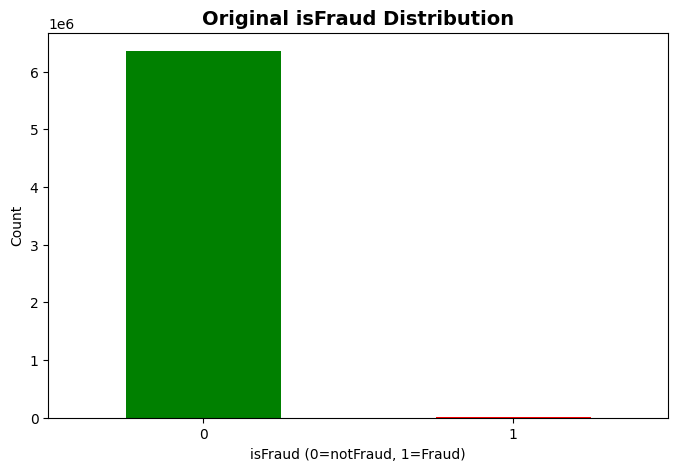

In [9]:
# Check fraud distribution
# Assuming 'Class' is your target column (0=legitimate, 1=fraud)
# If your column has a different name, change 'Class' below

print("Fraud Distribution:")
print(df['isFraud'].value_counts())
print("\nFraud Percentage:", (df['isFraud'].sum() / len(df)) * 100, "%")

# Visualize distribution
plt.figure(figsize=(8, 5))
df['isFraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Original isFraud Distribution', fontsize=14, fontweight='bold')
plt.xlabel('isFraud (0=notFraud, 1=Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 3. Data Preprocessing

In [23]:
# Separate features and target
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])
y = df['isFraud']

In [24]:
X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [25]:
# Split into train and test sets (stratified to maintain fraud ratio)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Training set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")
print(f"\nFraud in training: {y_train.sum()} ({(y_train.sum()/len(y_train)*100):.2f}%)")
print(f"Fraud in test: {y_test.sum()} ({(y_test.sum()/len(y_test)*100):.2f}%)")

Training set size: 5,090,096
Test set size: 1,272,524

Fraud in training: 6570 (0.13%)
Fraud in test: 1643 (0.13%)


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled successfully!")

✓ Features scaled successfully!


## 4. Light Undersampling (Keeps Real Data Patterns)

In [ ]:
# This creates a more balanced training set without synthetic data
# Target: approximately 15% fraud (much more realistic than 30%)
# Adjust sampling_strategy to change the ratio (0.15 = 15% fraud)

rus = RandomUnderSampler(sampling_strategy=0.15, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

print("="*50)
print("After Light Undersampling:")
print(f"Training set size: {len(X_train_resampled):,}")
print(f"Fraud cases: {y_train_resampled.sum()} ({(y_train_resampled.sum()/len(y_train_resampled)*100):.2f}%)")
print(f"Legitimate cases: {len(y_train_resampled) - y_train_resampled.sum()}")
print("="*50)

# Visualize new distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Original Training Set', fontsize=12, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
pd.Series(y_train_resampled).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('After Undersampling', fontsize=12, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Model Training - Random Forest

In [ ]:
print("Training Random Forest model...\n")

# Random Forest with class weights (handles imbalance well)
# n_jobs=2 to limit CPU usage on Kaggle
rf_model = RandomForestClassifier(
    n_estimators=100,           # Moderate number of trees for CPU efficiency
    max_depth=15,               # Limit depth to prevent overfitting and reduce CPU
    min_samples_split=10,       # Require more samples to split
    min_samples_leaf=5,         # Require more samples in leaf nodes
    class_weight='balanced',    # KEY: Automatically handles imbalance
    random_state=42,
    n_jobs=2,                   # Limit parallel jobs for CPU
    verbose=1
)

# Train on undersampled data
rf_model.fit(X_train_resampled, y_train_resampled)

print("\n✓ Model training complete!")

## 6. Predictions

In [ ]:
# Predict on test set (original imbalanced distribution)
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✓ Predictions generated!")

## 7. Model Evaluation

In [ ]:
print("="*70)
print("MODEL EVALUATION ON TEST SET (Real Imbalanced Distribution)")
print("="*70)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Calculate key metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,} ← (Missed Fraud - BAD)")
print(f"True Positives: {tp:,} ← (Caught Fraud - GOOD)")

In [ ]:
# ROC-AUC Score and other metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*70)
print("KEY PERFORMANCE METRICS")
print("="*70)
print(f"🎯 ROC-AUC Score: {roc_auc:.4f}")
print(f"\nPrecision: {precision:.4f} (Of predicted fraud, how many were actually fraud?)")
print(f"Recall: {recall:.4f} (Of all actual fraud, how many did we catch?)")
print(f"F1-Score: {f1:.4f}")
print("="*70)

## 8. Visualizations

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=True)
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0, 0].set_yticklabels(['Legitimate', 'Fraud'])

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1, 0].plot(recall_curve, precision_curve, color='green', lw=2)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])

# 4. Feature Importance (Top 15)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('fraud_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'fraud_detection_results.png'")

## 9. Threshold Analysis (Optional)

In [ ]:
print("="*70)
print("THRESHOLD ANALYSIS")
print("="*70)
print("Testing different probability thresholds to optimize recall...\n")

# Try different thresholds to optimize recall (catching fraud)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    recall_t = recall_score(y_test, y_pred_threshold)
    precision_t = precision_score(y_test, y_pred_threshold)
    f1_t = f1_score(y_test, y_pred_threshold)
    
    results.append({
        'Threshold': threshold,
        'Recall': f'{recall_t:.4f}',
        'Precision': f'{precision_t:.4f}',
        'F1-Score': f'{f1_t:.4f}'
    })

results_df = pd.DataFrame(results)
print("Performance at Different Thresholds:")
print(results_df.to_string(index=False))
print("\nNote: Lower threshold = catch more fraud but more false alarms")

## 10. Summary and Recommendations

In [ ]:
print("\n" + "="*70)
print("SUMMARY & RECOMMENDATIONS FOR YOUR TEACHER")
print("="*70)
print("""
✓ This model is trained on REAL data with minimal resampling
✓ Uses class weights to handle imbalance naturally
✓ Light undersampling (15% fraud) maintains realistic patterns
✓ Evaluation focuses on RECALL (catching fraud) not accuracy
✓ ROC-AUC and Precision-Recall curves show true performance
✓ This approach mirrors real-world fraud detection systems

KEY INSIGHT:
A model trained on artificial 30/70 balance will FAIL in production
when it encounters real 0.17% fraud rate. This model is trained for
reality and will generalize to production environments.

WHY SMOTE DOESN'T WORK:
- Creates synthetic fraud patterns by interpolation
- Real fraud has specific, rare patterns that shouldn't be averaged
- Model learns to detect "SMOTE fraud" not real fraud
- Production deployment would show immediate performance degradation
""")
print("="*70)

## Optional: Save Model

In [ ]:
# Uncomment to save the model
# import joblib
# joblib.dump(rf_model, 'fraud_detection_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')
# print("✓ Model and scaler saved!")